In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

## ANN for Regression

### Create data:

In [16]:
# create data

N = 30
x = torch.randn(N,1)
y = x + torch.randn(N,1)/2

# and plot
plt.plot(x,y,'s')
plt.show()

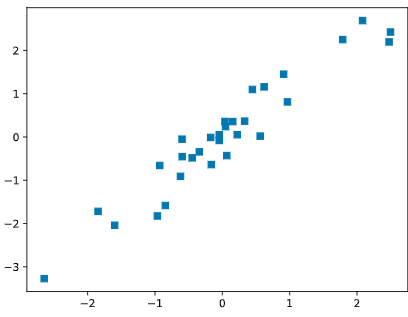

### Build the model:

__nn.Sequential__: a container module allowing to stack layers of a neural network in a sequential manner.

__nn.Linear(in_features, out_features)__: a linear (fully connected) layer 

__nn.ReLU()__: Adding a Rectified Linear Unit (ReLU) activation function: f(x) = max(0, x), which introduces non-linearity to the model.
The ReLU is commonly used because it helps to mitigate the vanishing gradient problem and allows models to learn faster.

In [3]:
ANNreg = nn.Sequential(
    nn.Linear(1, 1),  # input layer
    nn.ReLU(),        # activation function
    nn.Linear(1, 1)   # output layer
)

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

Sequential(<br>
  (0): Linear(in_features=1, out_features=1, bias=True)<br>
  (1): ReLU()<br>
  (2): Linear(in_features=1, out_features=1, bias=True)<br>
)

In [4]:
learningRate = .05

lossfun = nn.MSELoss()

# the flavor(type) of gradient descent to implement
# SGD: stochastic gradient descent
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

### Train the model:
    
all models will look like these 3 steps

In [5]:
numepochs = 500
losses = torch.zeros(numepochs)


## Train the model!
for epochi in range(numepochs):

  # forward pass: yHat is the final prediction of the model
  # It has a shape of: (30, 1) 
  yHat = ANNreg(x)

  # compute loss (squared error of actual and predicted)
  loss = lossfun(yHat,y)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad() # Clears the gradients of all optimized parameters
  loss.backward() # Computes the gradient of the loss with respect to the model parameters
  optimizer.step() # Updates the model parameters based on the computed gradients

### Show the losses:

In [17]:
# manually compute losses
# final forward pass (one more!)
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions-y).pow(2).mean() # so this is actually cost as we get the mean for all

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.plot(numepochs,testloss.detach(),'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())
plt.show()

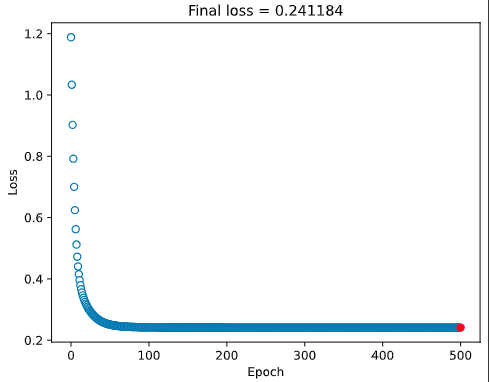

In [18]:
# plot the data
plt.plot(x,y,'bo',label='Real data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f'prediction-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}')
plt.legend()
plt.show()
# If you ended up with a horizontal line, try to increase # of epochs

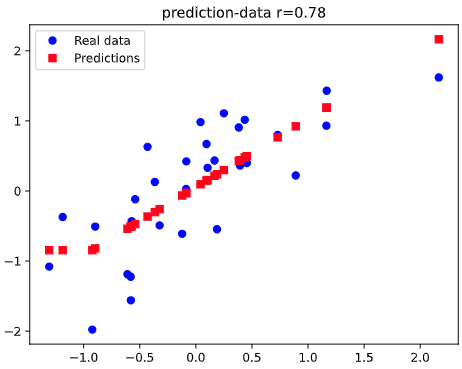

## ANN for Classification

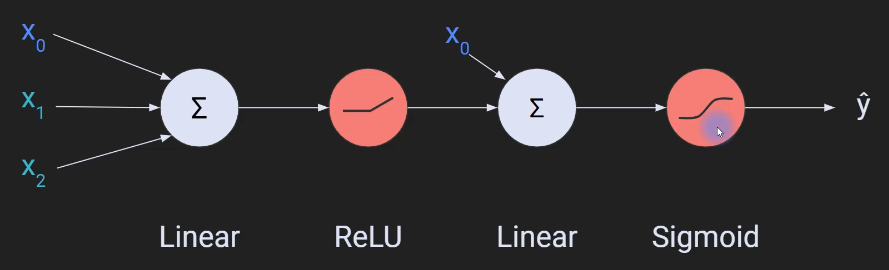

### Create data:

In [107]:
nPerClust = 100
blur = 1

# Centers:
A = [  1, 1 ]
B = [  5, 1 ]

# 100 points for each group: (two lists, each with len = 2)
# [array([ .., .., .., ...]), array([ .., .., .., ...])
# a = [aaa1, aaa2], b = [bbb1, bbb2]
a = [ A[0]+np.random.randn(nPerClust)*blur ,
     A[1]+np.random.randn(nPerClust)*blur
    ]

b = [ B[0]+np.random.randn(nPerClust)*blur ,
     B[1]+np.random.randn(nPerClust)*blur
    ]

# true labels (column vector (200,1):
#                100 zeros, following by 100 ones)
labels_np = np.vstack(
    (np.zeros((nPerClust,1)),np.ones((nPerClust,1)))
)

# concatanate into a matrix (200, 2)
# [a1 a2
# a1  a2
# a1  a2
# b1  b2
# b1  b2
# b1  b2]
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor (with dtype float32)
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

### Show data:

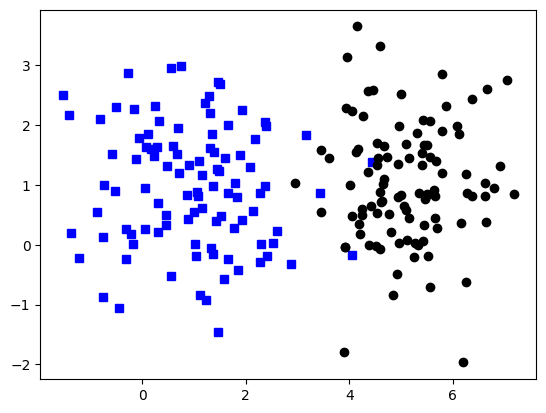

In [108]:
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.show()

### Build the model:

In [121]:
ANNclassify = nn.Sequential(
    nn.Linear(2,1),   # input layer (Now we give it two features: x,y)
    nn.ReLU(),        # activation unit
    nn.Linear(1,1),   # output unit
    nn.Sigmoid(),     # final activation unit (here for conceptual reasons; in practice, better to use BCEWithLogitsLoss)
      )

In [122]:
# other model features

learningRate = .01

# loss function
lossfun = nn.BCELoss()
# Note: You'll learn in the "Metaparameters" section that it's better to use BCEWithLogitsLoss,
# and remove the final nn.Sigmoid(), but this is OK for now.

# optimizer
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

In [123]:
# train the model
numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  # forward pass
  yHat = ANNclassify(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

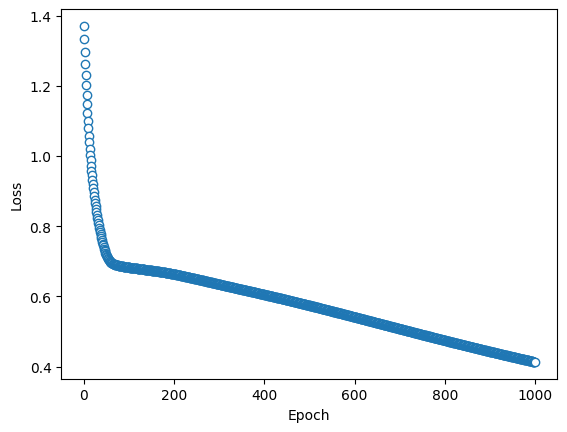

In [124]:
# show the losses

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [125]:
# compute the predictions

# manually compute losses
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions>.5

# find errors
misclassified = np.where(predlabels != labels)[0]

# total accuracy
totalacc = 100-100*len(misclassified)/(2*nPerClust)

print('Final accuracy: %g%%' %totalacc)

Final accuracy: 94%


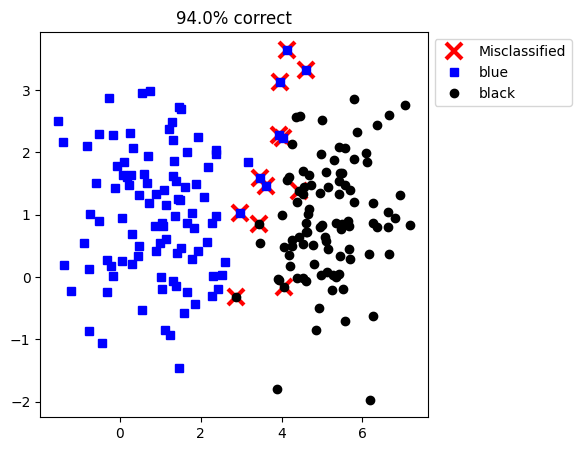

In [126]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predlabels)[0],0],data[np.where(~predlabels)[0],1],'bs')
plt.plot(data[np.where(predlabels)[0],0] ,data[np.where(predlabels)[0],1] ,'ko')

plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1))
plt.title(f'{totalacc}% correct')
plt.show()